In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, int64

In [1]:
def gray_flip(tau):
    k = tau[0]
    N = len(tau) - 1
    if k > N:
        return k, tau

    tau[k - 1] = tau[k]
    tau[k] = k + 1

    if k != 1:
        tau[0] = 1

    return k, tau

def generate_spins_configurations(N):
    # Inicializamos tau y spins
    tau = list(range(1, N + 2))  # {1, ..., N+1}
    spins = [-1] * (N + 1)       # {-, -, ..., -}

    # Generamos las configuraciones y las imprimimos
    total_configurations = 2**N
    print(f"Total de configuraciones para N={N}: {total_configurations}\n")
    
    for i in range(total_configurations):
        # Imprimimos la configuración actual
        print(f" {i+1}: {['+' if x == 1 else '-' for x in spins[1:]]}")
        
        # Usamos gray-flip para obtener la siguiente configuración
        k, tau = gray_flip(tau)
        
        # Cambiamos el spin correspondiente solo si k <= N
        if k <= N:
            spins[k] = -spins[k]

# Prueba con un número pequeño de spins N=4
generate_spins_configurations(4)

Total de configuraciones para N=4: 16

 1: ['-', '-', '-', '-']
 2: ['+', '-', '-', '-']
 3: ['+', '+', '-', '-']
 4: ['-', '+', '-', '-']
 5: ['-', '+', '+', '-']
 6: ['+', '+', '+', '-']
 7: ['+', '-', '+', '-']
 8: ['-', '-', '+', '-']
 9: ['-', '-', '+', '+']
 10: ['+', '-', '+', '+']
 11: ['+', '+', '+', '+']
 12: ['-', '+', '+', '+']
 13: ['-', '+', '-', '+']
 14: ['+', '+', '-', '+']
 15: ['+', '-', '-', '+']
 16: ['-', '-', '-', '+']


In [3]:
def gray_flip(tau):
    k = tau[0]
    N = len(tau) - 1
    if k > N:
        return k, tau

    tau[k - 1] = tau[k]
    tau[k] = k + 1

    if k != 1:
        tau[0] = 1

    return k, tau

def calcular_energia_local(spins, L, i, j, periodico=True):
    # Calcula la energía local alrededor del spin (i, j)
    spin = spins[i, j]
    E_local = 0

    if periodico:
        # Condiciones periódicas
        E_local -= spin * (spins[i, (j+1)%L] + spins[i, (j-1)%L] + spins[(i+1)%L, j] + spins[(i-1)%L, j])
    else:
        # Condiciones no periódicas
        if j < L-1:
            E_local -= spin * spins[i, j+1]  # Vecino derecha
        if j > 0:
            E_local -= spin * spins[i, j-1]  # Vecino izquierda
        if i < L-1:
            E_local -= spin * spins[i+1, j]  # Vecino abajo
        if i > 0:
            E_local -= spin * spins[i-1, j]  # Vecino arriba

    return E_local

def enumerate_ising(L, periodico=True):
    N = L * L  # Total de spins en la red cuadrada LxL
    tau = list(range(1, N + 2))  # Inicializamos tau {1, ..., N+1}
    spins = np.ones((L, L), dtype=np.int8) * -1  # Inicializamos los spins (-1 en todas las posiciones)
    
    N_E = {}
    E = 0  # Energía inicial
    for i in range(L):
        for j in range(L):
            E += calcular_energia_local(spins, L, i, j, periodico) / 2  # Cada par de spins se cuenta 2 veces
    N_E[E] = np.int64(1)  # Usamos un tipo de dato grande para contar
    
    total_configurations = 2**N
    for i in range(1, total_configurations):
        # Usamos gray-flip para cambiar los spins
        k, tau = gray_flip(tau)
        fila, columna = divmod(k-1, L)
        
        # Restamos la energía local previa
        E -= calcular_energia_local(spins, L, fila, columna, periodico)
        
        # Flipeamos el spin correspondiente
        spins[fila, columna] *= -1
        
        # Añadimos la nueva energía local
        E += calcular_energia_local(spins, L, fila, columna, periodico)
        
        # Guardamos la densidad de estados
        if E in N_E:
            N_E[E] += np.int64(1)  # Usamos np.int64 para números grandes
        else:
            N_E[E] = np.int64(1)

    return N_E

def imprimir_resultados_en_tabla(resultados, L, periodico):
    tipo = "periódico" if periodico else "no periódico"
    print(f"Densidad de estados para la red {L}x{L} ({tipo}):")
    print(f"{'E':^10} | {'N(E)':^15}")
    print("-" * 30)
    
    # Energías posibles
    energias_posibles = sorted(resultados.keys())
    
    # Filas de la tabla
    for energia in energias_posibles:
        print(f"{energia:^10} | {resultados[energia]:^15}")

In [4]:
# Caso para 2x2 con y sin condiciones periódicas
L = 2  # Aquí se puede modificar a 4 o 6 para otras redes

# Densidad de estados para condiciones periódicas
resultados_periodico = enumerate_ising(L, periodico=True)
imprimir_resultados_en_tabla(resultados_periodico, L, periodico=True)

# Densidad de estados para condiciones no periódicas
resultados_no_periodico = enumerate_ising(L, periodico=False)
imprimir_resultados_en_tabla(resultados_no_periodico, L, periodico=False)

Densidad de estados para la red 2x2 (periódico):
    E      |      N(E)      
------------------------------
   -8.0    |        2       
   0.0     |       12       
   8.0     |        2       
Densidad de estados para la red 2x2 (no periódico):
    E      |      N(E)      
------------------------------
   -4.0    |        2       
   0.0     |       12       
   4.0     |        2       


In [5]:
L = 4  

# Densidad de estados para condiciones periódicas
resultados_periodico = enumerate_ising(L, periodico=True)
imprimir_resultados_en_tabla(resultados_periodico, L, periodico=True)

# Densidad de estados para condiciones no periódicas
resultados_no_periodico = enumerate_ising(L, periodico=False)
imprimir_resultados_en_tabla(resultados_no_periodico, L, periodico=False)

Densidad de estados para la red 4x4 (periódico):
    E      |      N(E)      
------------------------------
  -32.0    |        2       
  -24.0    |       32       
  -20.0    |       64       
  -16.0    |       424      
  -12.0    |      1728      
   -8.0    |      6688      
   -4.0    |      13568     
   0.0     |      20524     
   4.0     |      13568     
   8.0     |      6688      
   12.0    |      1728      
   16.0    |       424      
   20.0    |       64       
   24.0    |       32       
   32.0    |        2       
Densidad de estados para la red 4x4 (no periódico):
    E      |      N(E)      
------------------------------
  -24.0    |        2       
  -20.0    |        8       
  -18.0    |       32       
  -16.0    |       72       
  -14.0    |       224      
  -12.0    |       584      
  -10.0    |      1216      
   -8.0    |      2638      
   -6.0    |      4928      
   -4.0    |      7344      
   -2.0    |      9984      
   0.0     |      11472  

In [6]:
def gray_flip(tau):
    k = tau[0]
    N = len(tau) - 1
    if k > N:
        return k, tau

    tau[k - 1] = tau[k]
    tau[k] = k + 1

    if k != 1:
        tau[0] = 1

    return k, tau

def calcular_energia_local(spins, L, i, j, periodico=True):
    spin = spins[i, j]
    E_local = 0
    if periodico:
        E_local -= spin * (spins[i, (j+1)%L] + spins[i, (j-1)%L] + spins[(i+1)%L, j] + spins[(i-1)%L, j])
    else:
        if j < L-1:
            E_local -= spin * spins[i, j+1]
        if j > 0:
            E_local -= spin * spins[i, j-1]
        if i < L-1:
            E_local -= spin * spins[i+1, j]
        if i > 0:
            E_local -= spin * spins[i-1, j]
    return E_local

def enumerate_ising_magnetizacion(L, periodico=True):
    N = L * L
    tau = list(range(1, N + 2))  # Tau para gray-flip
    spins = np.ones((L, L), dtype=np.int8) * -1  # Todos los spins inicializan en -1
    
    N_EM = {}  # Diccionario para almacenar N(E, M)
    E = 0
    M = spins.sum()  # Magnetización inicial

    for i in range(L):
        for j in range(L):
            E += calcular_energia_local(spins, L, i, j, periodico) / 2
    
    # Inicializamos N(E, M)
    N_EM[(E, M)] = np.int64(1)
    
    total_configurations = 2**N
    for i in range(1, total_configurations):
        k, tau = gray_flip(tau)
        fila, columna = divmod(k-1, L)
        
        E -= calcular_energia_local(spins, L, fila, columna, periodico)
        spins[fila, columna] *= -1
        M = spins.sum()  # Actualizamos la magnetización
        E += calcular_energia_local(spins, L, fila, columna, periodico)
        
        # Actualizamos N(E, M)
        if (E, M) in N_EM:
            N_EM[(E, M)] += np.int64(1)
        else:
            N_EM[(E, M)] = np.int64(1)

    return N_EM


In [7]:
# Constante de Boltzmann k_B, lo tomamos como 1 para simplificar
k_B = 1

def calcular_pi_M(N_EM, L, T):
    """
    Calcula la distribución de la magnetización por spin pi_M para una red LxL a una temperatura T.
    
    :param N_EM: Diccionario con las configuraciones N(E, M)
    :param L: Tamaño de la red (LxL)
    :param T: Temperatura
    :return: Diccionario con pi_M (probabilidad de magnetización M)
    """
    N = L * L
    beta = 1 / (k_B * T)
    
    # Diccionario para sumar pi_M
    pi_M = {}
    Z = 0  # Partición
    
    # Sumar sobre todas las configuraciones para calcular la partición Z
    for (E, M), count in N_EM.items():
        boltzmann_factor = np.exp(-beta * E)
        Z += count * boltzmann_factor
        
        if M in pi_M:
            pi_M[M] += count * boltzmann_factor
        else:
            pi_M[M] = count * boltzmann_factor
    
    # Normalizamos pi_M dividiendo por Z
    for M in pi_M:
        pi_M[M] /= Z
    
    return pi_M

def plot_pi_M(pi_M, L, T):
    """
    Grafica la distribución de magnetización por spin pi_M.
    
    :param pi_M: Diccionario con pi_M (probabilidad de magnetización M)
    :param L: Tamaño de la red (LxL)
    :param T: Temperatura
    """
    M_vals = sorted(pi_M.keys())
    pi_vals = [pi_M[M] for M in M_vals]
    
    plt.figure(figsize=(8, 6))
    plt.bar(M_vals, pi_vals, width=1.0)
    plt.xlabel("Magnetización total M")
    plt.ylabel("Probabilidad pi_M")
    plt.title(f"Distribución de magnetización para {L}x{L} a T = {T}")
    plt.grid(True)
    plt.show()


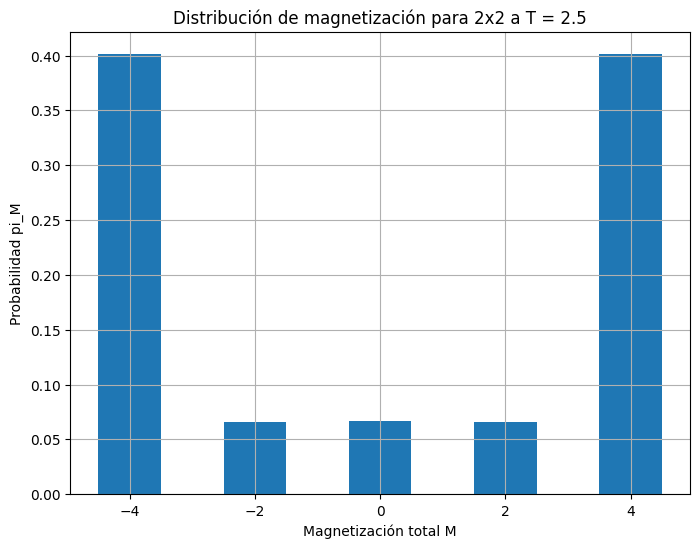

In [8]:
L = 2
T = 2.5  
resultados_2x2_periodico = enumerate_ising_magnetizacion(L, periodico=True)
pi_M_2x2 = calcular_pi_M(resultados_2x2_periodico, L, T)
plot_pi_M(pi_M_2x2, L, T)

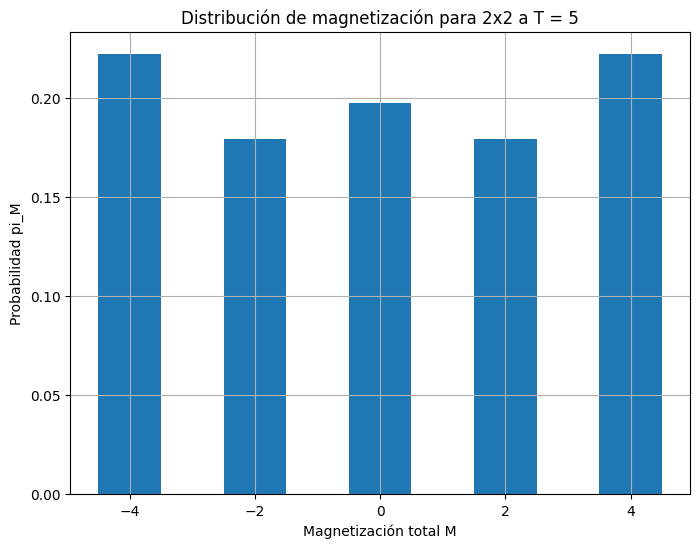

In [9]:
# Ejemplo de uso para una red 2x2
L = 2
T = 5  # Ejemplo de temperatura
resultados_2x2_periodico = enumerate_ising_magnetizacion(L, periodico=True)
pi_M_2x2 = calcular_pi_M(resultados_2x2_periodico, L, T)
plot_pi_M(pi_M_2x2, L, T)

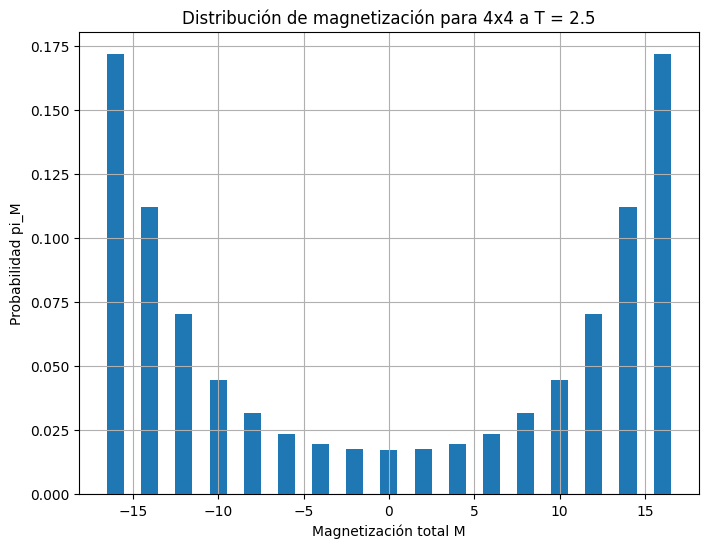

In [10]:
L = 4
T = 2.5  # Ejemplo de temperatura
resultados_2x2_periodico = enumerate_ising_magnetizacion(L, periodico=True)
pi_M_2x2 = calcular_pi_M(resultados_2x2_periodico, L, T)
plot_pi_M(pi_M_2x2, L, T)

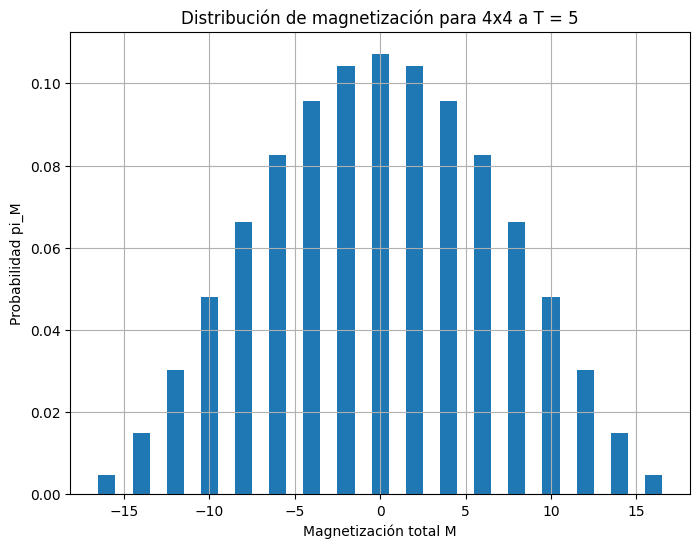

In [11]:
L = 4
T = 5 # Ejemplo de temperatura
resultados_2x2_periodico = enumerate_ising_magnetizacion(L, periodico=True)
pi_M_2x2 = calcular_pi_M(resultados_2x2_periodico, L, T)
plot_pi_M(pi_M_2x2, L, T)

In [12]:
def calcular_momentos(pi_M):
    """
    Calcula los momentos de M, <M^2> y <M^4>.
    
    :param pi_M: Diccionario con pi_M (probabilidad de magnetización M)
    :return: <M^2>, <M^4>
    """
    M2 = 0
    M4 = 0
    for M, p in pi_M.items():
        M2 += M**2 * p
        M4 += M**4 * p
    return M2, M4

def calcular_binder_cumulant(pi_M):
    """
    Calcula el Binder cumulant B(T) usando pi_M.
    
    :param pi_M: Diccionario con pi_M (probabilidad de magnetización M)
    :return: Valor del Binder cumulant B(T)
    """
    M2, M4 = calcular_momentos(pi_M)
    B_T = 0.5 * (3 - M4 / M2**2)
    return B_T

# Calcular Binder cumulant para la red 2x2
binder_2x2 = calcular_binder_cumulant(pi_M_2x2)
print(f"Binder cumulant para la red 2x2 a T = {T}: {binder_2x2}")

Binder cumulant para la red 2x2 a T = 5: 0.31178964760909134
